# Improving The Code

The performance of my code is not very good now. Let's take a look.

In [2]:
import numpy as np
import pandas as pd
import finite_difference

In [40]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 100.,  # preco do ativo
           "f_sigma": 0.2, # desvio padra do ativo objeto
           "f_time": 1.,  # tempo para vencimento em anos
           "f_r": 0.05,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "f_K": 100.  # strike da opcao
          }

%time my_option = finite_difference.EuropianCall(**d_param)

CPU times: user 1.07 s, sys: 12 ms, total: 1.08 s
Wall time: 1.08 s


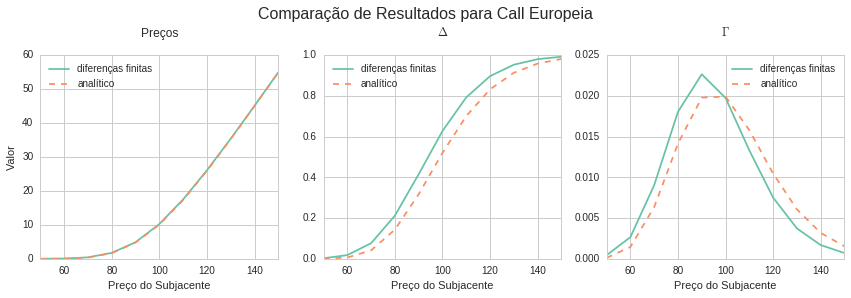

In [41]:
# plotando graficos do inicio do periodo
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])    

In [56]:
df_opt = my_option.df_opt_prices
df_opt.tail(15).head(9).iloc[:, 0:20:2]

,0.0,0.111111111111,0.222222222222,0.333333333333,0.444444444444,0.555555555556,0.666666666667,0.777777777778,0.888888888889,1.0
60.0,0.0,0.000000,0.000000,0.000173,0.001259,0.004486,0.011279,0.023036,0.040980,0.066094
70.0,0.0,0.000000,0.000676,0.007757,0.028168,0.066767,0.126065,0.206760,0.308349,0.429631
80.0,0.0,0.000000,0.036608,0.140811,0.310256,0.533585,0.798786,1.095650,1.416173,1.754280
90.0,0.0,0.128125,0.592152,1.181664,1.812239,2.449705,3.080486,3.699585,4.305587,4.898543
100.0,0.0,2.253472,3.819229,5.054272,6.109311,7.054239,7.924756,8.740918,9.515021,10.255185
110.0,10.0,10.670640,11.587389,12.534691,13.455152,14.336805,15.180467,15.990032,16.769645,17.522967
120.0,20.0,20.554784,21.158845,21.825706,22.528714,23.246788,23.967303,24.683313,25.391170,26.089063
130.0,30.0,30.554784,31.109308,31.679665,32.271549,32.881648,33.504330,34.134408,34.767822,35.401596
140.0,40.0,40.554784,41.106490,41.657559,42.213263,42.776566,43.347774,43.925717,44.508690,45.094945


Let's see if I can improve that

In [113]:
def opt_value(f_vol, f_intrate, s_ptype, f_strike, f_expiration, f_NAS):
    '''
    Wilmott implementation of finite difference method
    '''
    i_NAS = int(f_NAS)
    dS = 2 * f_strike / f_NAS
    dt = 0.9 / f_vol ** 2 / f_NAS**2
    i_NTS = int(f_expiration/dt) + 1
    dt = f_expiration / float(i_NTS)

    
    na_S = np.zeros(i_NAS + 1)
    na_V = np.zeros([i_NAS + 1, i_NTS+1])
    na_Delta = np.zeros([i_NAS + 1, i_NTS+1])
    na_Gamma = np.zeros([i_NAS + 1, i_NTS+1])
    
    q = 1
    if s_ptype=='P':
        q = -1
        
    for i in xrange(i_NAS+1):
        na_S[i] = i * dS
        na_V[i][0] = max(q * (na_S[i] - f_strike), 0)
    
    for k in xrange(1, i_NTS+1):
        for i in xrange(1, i_NAS):
            f_delta = (na_V[i+1][k-1] - na_V[i-1][k-1]) / (2.*dS)
            f_gamma = (na_V[i+1][k-1] - 2 * na_V[i][k-1] + na_V[i-1][k-1])
            f_gamma /= dS**2 
            f_theta = -0.5*f_vol**2 * na_S[i]**2 * f_gamma
            f_theta -= f_intrate*na_S[i]*f_delta
            f_theta += f_intrate * na_V[i][k-1]
            na_Delta[i][k] = f_delta
            na_Gamma[i][k] = f_gamma
            na_V[i][k] = na_V[i][k-1] - dt * f_theta
        na_V[0][k] = na_V[0][k-1] * (1. - f_intrate * dt)
        na_V[i_NAS][k] = 2 * na_V[i_NAS-1][k] - na_V[i_NAS-2][k]
    
    df_price = pd.DataFrame(na_V)
    df_gamma = pd.DataFrame(na_Gamma)
    df_delta = pd.DataFrame(na_Delta)
    for df in [df_price, df_gamma, df_delta]:
        df.index = na_S
        df.columns = np.arange(i_NTS+1) * dt
    
    
    return df_price, df_delta, df_gamma

In [117]:
d = {'f_vol': 0.2,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'f_strike': 100.,
     'f_expiration': 1.,
     'f_NAS': 20.}

df_price, df_delta, df_gamma = opt_value(**d)

In [118]:
df_price.tail(15).head(9).iloc[:, 0:20:2]

,0.0,0.111111111111,0.222222222222,0.333333333333,0.444444444444,0.555555555556,0.666666666667,0.777777777778,0.888888888889,1.0
60.0,0.0,0.000000,0.000000,0.000173,0.001259,0.004486,0.011279,0.023036,0.040980,0.066094
70.0,0.0,0.000000,0.000676,0.007757,0.028168,0.066767,0.126065,0.206760,0.308349,0.429631
80.0,0.0,0.000000,0.036608,0.140811,0.310256,0.533585,0.798786,1.095650,1.416173,1.754280
90.0,0.0,0.128125,0.592152,1.181664,1.812239,2.449705,3.080486,3.699585,4.305587,4.898543
100.0,0.0,2.253472,3.819229,5.054272,6.109311,7.054239,7.924756,8.740918,9.515021,10.255185
110.0,10.0,10.670640,11.587389,12.534691,13.455152,14.336805,15.180467,15.990032,16.769645,17.522967
120.0,20.0,20.554784,21.158845,21.825706,22.528714,23.246788,23.967303,24.683313,25.391170,26.089063
130.0,30.0,30.554784,31.109308,31.679665,32.271549,32.881648,33.504330,34.134408,34.767822,35.401596
140.0,40.0,40.554784,41.106490,41.657559,42.213263,42.776566,43.347774,43.925717,44.508690,45.094945


Nice... now, let's compare them

In [119]:
%timeit df_test = opt_value(**d)

100 loops, best of 3: 3.27 ms per loop


In [110]:
%timeit my_option = finite_difference.EuropianCall(**d_param)

1 loop, best of 3: 815 ms per loop


It looks bad...but... Let use my implementation, but without calculate the analitical values

In [111]:
reload(finite_difference)

<module 'finite_difference' from 'finite_difference.py'>

In [123]:
%timeit my_option = finite_difference.EuropianCall(**d_param)

1 loop, best of 3: 1.06 s per loop


Ok... much better, but it is still much worst than the function created here. Now, let me see the plots of each solution

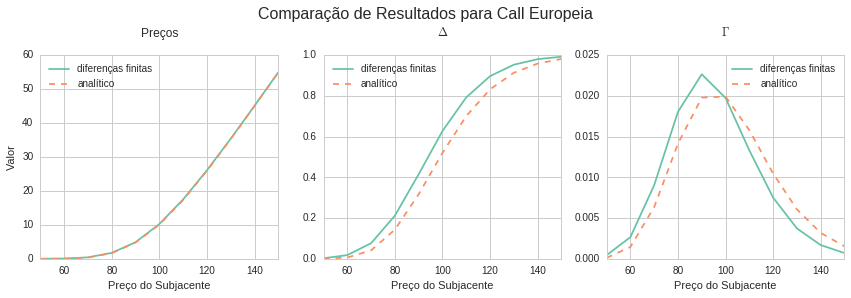

In [124]:
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

In [125]:
my_option.df_delta = df_delta
my_option.df_opt_prices = df_price
my_option.df_gamma = df_gamma

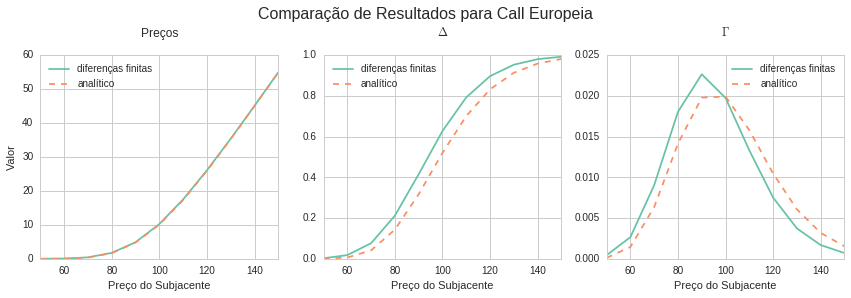

In [126]:
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Now, let's compare the results using uncertain volatility

In [135]:
def opt_value_uvm(f_volm, f_volM, f_intrate, s_ptype, f_strike, f_expiration, f_NAS):
    '''
    Wilmott implementation of finite difference method
    '''
    i_NAS = int(f_NAS)
    dS = 2 * f_strike / f_NAS
    dt = 0.9 / f_volm ** 2 / f_NAS**2
    i_NTS = int(f_expiration/dt) + 1
    dt = f_expiration / float(i_NTS)
    f_sigma = (f_volm+f_volM)/2.

    
    na_S = np.zeros(i_NAS + 1)
    na_V = np.zeros([i_NAS + 1, i_NTS+1])
    na_Delta = np.zeros([i_NAS + 1, i_NTS+1])
    na_Gamma = np.zeros([i_NAS + 1, i_NTS+1])
    
    q = 1
    if s_ptype=='P':
        q = -1
        
    for i in xrange(i_NAS+1):
        na_S[i] = i * dS
        na_V[i][0] = max(q * (na_S[i] - f_strike), 0)
    
    for k in xrange(1, i_NTS+1):
        for i in xrange(1, i_NAS):
            f_delta = (na_V[i+1][k-1] - na_V[i-1][k-1]) / (2.*dS)
            f_gamma = (na_V[i+1][k-1] - 2 * na_V[i][k-1] + na_V[i-1][k-1])
            f_gamma /= dS**2
            
            f_vol = f_sigma
            if f_gamma<0:
                f_vol = f_volM
            elif f_gamma>0:
                f_vol = f_volm
            
            f_theta = -0.5*f_vol**2 * na_S[i]**2 * f_gamma
            f_theta -= f_intrate*na_S[i]*f_delta
            f_theta += f_intrate * na_V[i][k-1]
            na_Delta[i][k] = f_delta
            na_Gamma[i][k] = f_gamma
            na_V[i][k] = na_V[i][k-1] - dt * f_theta
        na_V[0][k] = na_V[0][k-1] * (1. - f_intrate * dt)
        na_V[i_NAS][k] = 2 * na_V[i_NAS-1][k] - na_V[i_NAS-2][k]
    
    df_price = pd.DataFrame(na_V)
    df_gamma = pd.DataFrame(na_Gamma)
    df_delta = pd.DataFrame(na_Delta)
    for df in [df_price, df_gamma, df_delta]:
        df.index = na_S
        df.columns = np.arange(i_NTS+1) * dt
    
    
    return df_price, df_delta, df_gamma

In [143]:
d = {'f_volm': 0.10,
     'f_volM': 0.30,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'f_strike': 100.,
     'f_expiration': 1.,
     'f_NAS': 20.}

%time df_price, df_delta, df_gamma = opt_value_uvm(**d)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.68 ms


In [145]:
%timeit df_price, df_delta, df_gamma = opt_value_uvm(**d)

1000 loops, best of 3: 1.7 ms per loop


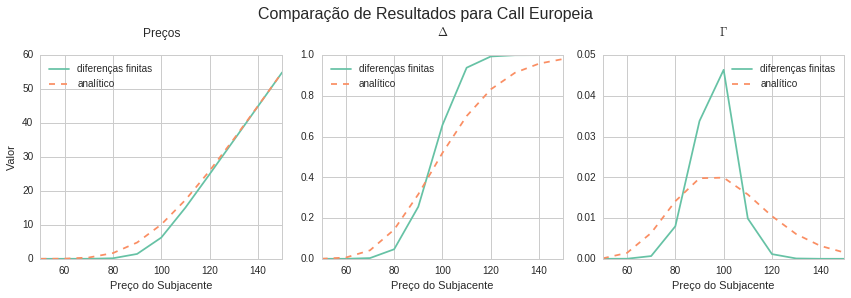

In [146]:
my_option.df_delta = df_delta
my_option.df_opt_prices = df_price
my_option.df_gamma = df_gamma
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

So far, so good. The only problem is that the function is very restrict... but it is OK. Now, let try with a butterfly. First, I will use the class already implemented

In [6]:
class FlyEuropianCall(finite_difference.Derivative):
    '''
    A representation of a europian Call Option
    '''
    def __init__(self, f_St, f_sigma, f_time, f_r, i_nas, l_K, l_Qty, i_nts=None):
        '''
        Initialize a EuropianCall object. Save all parameters as attributes
        :param f_St: float. The price of the underline asset
        :param f_sigma: float. A non negative underline volatility
        :param f_time: float. The time remain until the expiration
        :param f_r: float. The free intereset rate
        :param i_nas: integer. Number of asset steps
        :param f_K: float. The strike
        :*param i_nas: integer. Number of asset steps
        '''
        self.l_K = l_K
        self.l_Q = l_Qty
        # inicia variaveis de Derivativo
        super(FlyEuropianCall, self).__init__(f_St=f_St,
                                              f_sigma=f_sigma,
                                              f_time=f_time,
                                              f_r=f_r,
                                              i_nas=i_nas,
                                              f_K=max(l_K),
                                              i_nts=i_nts)
        self.s_name = 'Borboleta de Call Europeia'
        self._go_backwards()
        self._set_all_matrix()

    def _get_analytical_price(self, f_S, f_time):
        '''
        Return the price of the instrument using its analytical solution
        :param f_S: float. the asset price
        :param f_time: float.time to expiration
        '''
        f_rtn = 0.
        for f_K, f_Q in zip(self.l_K, self.l_Q):
            f_d1, f_d2 = finite_difference.get_d1_and_d2(f_S, self.f_sigma, f_time, self.f_r,
                                       f_K)
            exp_r_t = np.exp(-self.f_r * self.f_time)
            S_cdf_d1 = f_S * stats.norm.cdf(f_d1, 0., 1.)
            K_cdf_d2 = f_K * stats.norm.cdf(f_d2, 0., 1.)

            f_rtn += (S_cdf_d1 - K_cdf_d2 * exp_r_t) * f_Q
        
        return f_rtn

    def _get_analytical_delta(self, f_S, f_time):
        '''
        Return the delta of the instrument using its analytical solution
        :param f_S: float. the asset price
        :param f_time: float.time to expiration
        '''
        f_rtn = 0.
        for f_K, f_Q in zip(self.l_K, self.l_Q):
            f_d1, f_d2 = finite_difference.get_d1_and_d2(f_S, self.f_sigma, f_time, self.f_r,
                                       f_K)
            cdf_d1 = stats.norm.cdf(f_d1, 0., 1.)
            f_rtn += cdf_d1 * f_Q
        return f_rtn

    def _get_analytical_gamma(self, f_S, f_time):
        '''
        Return the gamma of the instrument using its analytical solution
        :param f_S: float. the asset price
        :param f_time: float.time to expiration
        '''
        f_rtn = 0.
        for f_K, f_Q in zip(self.l_K, self.l_Q):
            f_d1, f_d2 = finite_difference.get_d1_and_d2(f_S, self.f_sigma, f_time, self.f_r,
                                       f_K)
            pdf_d1 = stats.norm.pdf(f_d1, 0., 1.)
            S_gima_sqrt_t = f_S * self.f_sigma * (f_time**0.5)
            f_rtn += (pdf_d1/S_gima_sqrt_t) * f_Q
        return f_rtn

    def _get_payoff(self, f_asset_price):
        '''
        Get the payoff of the contract
        :param f_asset_price: float. The base asset price
        '''
        f_rtn = 0.
        for f_K, f_Q in zip(self.l_K, self.l_Q):
            f_rtn += max(0, f_asset_price - f_K) * f_Q
        return f_rtn


Now, let's see at the expiration

In [47]:
# import libraries
import matplotlib.pylab as plt
import math
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import time

In [48]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 100.,  # preco do ativo
           "f_sigma": 0.2, # desvio padra do ativo objeto
           "f_time": 10e-6,  # tempo para vencimento em anos
           "f_r": 0.05,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "l_K": [90., 100., 110.],  # strike da opcao
           "l_Qty": [0.5, -1., 0.5]  # qtde por leg
          }

%time my_option = FlyEuropianCall(**d_param)

CPU times: user 114 ms, sys: 7.01 ms, total: 121 ms
Wall time: 117 ms


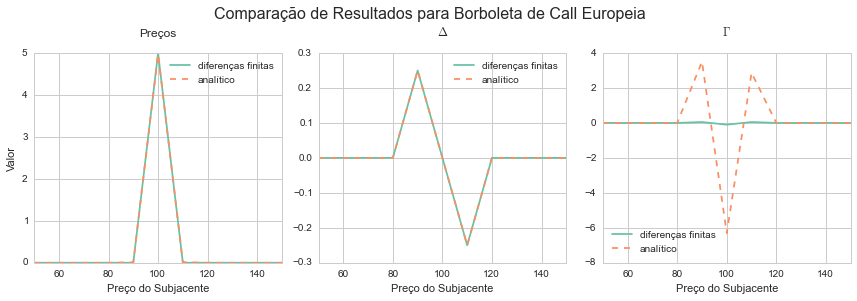

In [51]:
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

It is looking right. Now, let's see farther aways from expiration

In [52]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 100.,  # preco do ativo
           "f_sigma": 0.2, # desvio padra do ativo objeto
           "f_time": 1.,  # tempo para vencimento em anos
           "f_r": 0.05,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "l_K": [90., 100., 110.],  # strike da opcao
           "l_Qty": [0.5, -1., 0.5]  # qtde por leg
          }

%time my_option = FlyEuropianCall(**d_param)

CPU times: user 1.08 s, sys: 10.5 ms, total: 1.09 s
Wall time: 1.09 s


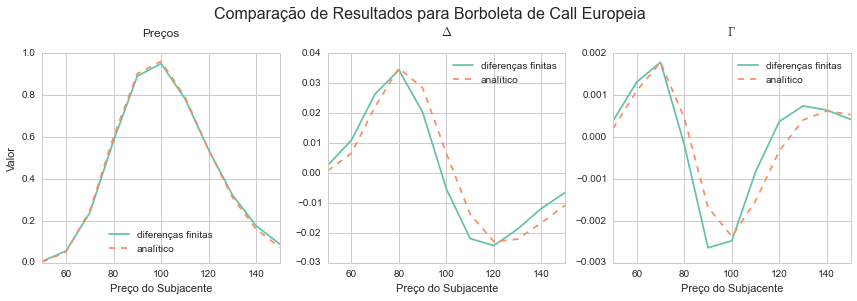

In [53]:
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Intresting... now, let's check using the function created

In [54]:
def opt_value_uvm_fly(f_volm, f_volM, f_intrate, s_ptype, l_strike, l_qty, f_expiration,
                      f_NAS, b_worstcase=True):
    '''
    Wilmott implementation of finite difference method
    '''
    i_NAS = int(f_NAS)
    dS = 2 * max(l_strike) / f_NAS
    dt = 0.9 / f_volM ** 2 / f_NAS**2
    i_NTS = int(f_expiration/dt) + 1
    dt = f_expiration / float(i_NTS)
    f_sigma = (f_volm+f_volM)/2.

    
    na_S = np.zeros(i_NAS + 1)
    na_V = np.zeros([i_NAS + 1, i_NTS+1])
    na_Delta = np.zeros([i_NAS + 1, i_NTS+1])
    na_Gamma = np.zeros([i_NAS + 1, i_NTS+1])
    
    q = 1
    if s_ptype=='P':
        q = -1
        
    for i in xrange(i_NAS+1):
        na_S[i] = i * dS
        f_rtn = 0
        for f_qty, f_K in zip(l_qty, l_strike):
            f_rtn += max(q * (na_S[i] - f_K), 0) * f_qty
        na_V[i][0] = f_rtn
    
    for k in xrange(1, i_NTS+1):
        for i in xrange(1, i_NAS):
            f_delta = (na_V[i+1][k-1] - na_V[i-1][k-1]) / (2.*dS)
            f_gamma = (na_V[i+1][k-1] - 2 * na_V[i][k-1] + na_V[i-1][k-1])
            f_gamma /= dS**2
            
#             f_vol = f_sigma
            if b_worstcase:
                # worst case scenario
                if f_gamma < 0.:
                    f_vol = f_volM
                elif f_gamma >= 0.:
                    f_vol = f_volm
            else:
                # best case scenario
                if f_gamma >= 0.:
                    f_vol = f_volM
                elif f_gamma < 0.:
                    f_vol = f_volm
            
            f_theta = -0.5*f_vol**2 * na_S[i]**2 * f_gamma
            f_theta -= f_intrate*na_S[i]*f_delta
            f_theta += f_intrate * na_V[i][k-1]
            na_Delta[i][k] = f_delta
            na_Gamma[i][k] = f_gamma
            na_V[i][k] = na_V[i][k-1] - dt * f_theta
        na_V[0][k] = na_V[0][k-1] * (1. - f_intrate * dt)
        na_V[i_NAS][k] = 2 * na_V[i_NAS-1][k] - na_V[i_NAS-2][k]
    
    df_price = pd.DataFrame(na_V)
    df_gamma = pd.DataFrame(na_Gamma)
    df_delta = pd.DataFrame(na_Delta)
    for df in [df_price, df_gamma, df_delta]:
        df.index = na_S
        df.columns = np.arange(i_NTS+1) * dt
    
    
    return df_price, df_delta, df_gamma

Testing at the expiration

In [55]:
d = {'f_volm': 0.15,
     'f_volM': 0.25,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'l_strike': [90., 100., 110.],
     'l_qty': [0.5, -1., 0.5],
     'f_expiration':10e-6,
     'f_NAS': 20.}

%time df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)

CPU times: user 1.43 ms, sys: 321 µs, total: 1.75 ms
Wall time: 1.54 ms


In [56]:
%timeit df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)

1000 loops, best of 3: 955 µs per loop


In [57]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 100.,  # preco do ativo
           "f_sigma": 0.2, # desvio padra do ativo objeto
           "f_time": 10e-6,  # tempo para vencimento em anos
           "f_r": 0.05,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "l_K": [90., 100., 110.],  # strike da opcao
           "l_Qty": [0.5, -1., 0.5]  # qtde por leg
          }

%time my_option = FlyEuropianCall(**d_param)

CPU times: user 122 ms, sys: 13.2 ms, total: 135 ms
Wall time: 127 ms


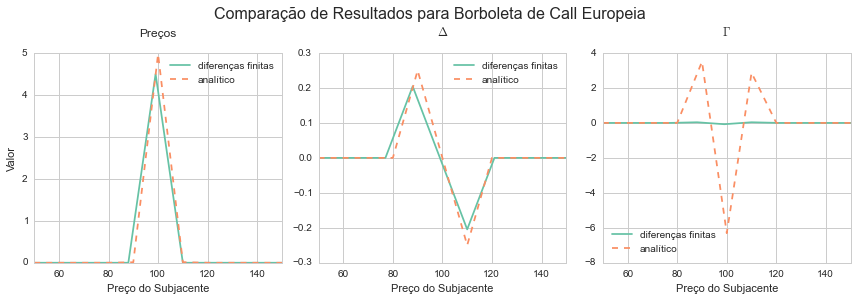

In [58]:
my_option.df_delta = df_delta
my_option.df_opt_prices = df_price
my_option.df_gamma = df_gamma
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Now further the expiration

In [59]:
d = {'f_volm': 0.15,
     'f_volM': 0.25,
     'f_intrate': 0.05,
     's_ptype': 'C',
     'l_strike': [90., 100., 110.],
     'l_qty': [0.5, -1., 0.5],
     'f_expiration':1.,
     'f_NAS': 20.}

%time df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)

CPU times: user 6.87 ms, sys: 1.7 ms, total: 8.57 ms
Wall time: 7.39 ms


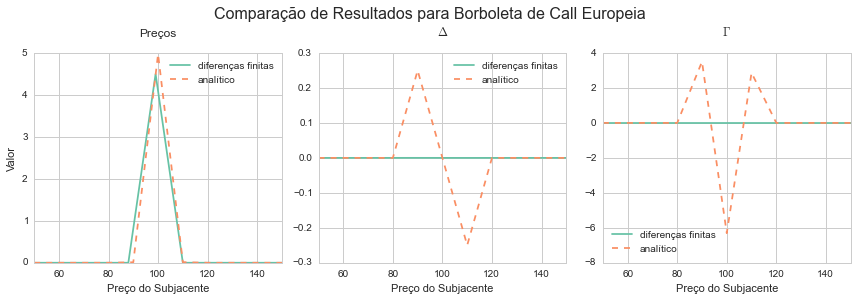

In [60]:
my_option.df_delta = df_delta
my_option.df_opt_prices = df_price
my_option.df_gamma = df_gamma
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Nice.... let's try to find the combination that will result in the best price. What I need to select is a vector $(\lambda_1, \lambda_2, ..., \lambda_n)$, that should be restricted to vary over a siotable range of portfolio combinations and optimize the following function for two options, when we want to get the price for the Bid:

$$f(\lambda_1, \lambda2) = \underset{\lambda_1, \,\lambda_2}{\arg \max}\, V(S_0, t_0\,; \lambda_1, \lambda_2)- \sum_{i=1}^{2} \lambda_{i} v_{i}^{-}(t_0, S_0)$$ 

Where $v_{i}^{-}$ is the prices of each option used in the hedging given by the market ($-$ denotes bid price and $+$, ask price). $V(S_0, t_0\,; \lambda_1, \lambda_2)$ is the price of the whole strategy. So, the function should be evaluated at the current date. Let's try

In [165]:
def best_price(na_x, f_middle, f_S0, na_V0, d_opt_param, f_max=1., b_rtn_price=False):
    '''
    Return the best price fo the option evaluated
    '''
    d = d_opt_param.copy()
    l_qty = list(na_x)[:]
    l_qty.insert(1, f_middle)
    d['l_qty'] = l_qty
    df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)
    f_V =  finite_difference.bilinear_interpolation(f_S0,
                                                    d['f_expiration'],
                                                    df_price)
    f_already_paid = sum(na_V0 * np.array(na_x))
    if b_rtn_price:
        return (f_V - f_already_paid) * f_middle * f_max, df_price   
    return (f_V - f_already_paid) * f_middle * f_max
    

First, let's check which price we would pay if we did a symetric butterfly

In [101]:
d = {'f_volm': 0.25,
     'f_volM': 0.40,
     'f_intrate': 0.00,
     's_ptype': 'P',
     'l_strike': [29., 32., 35.],
     'l_qty': [0., 1., 0.],
     'f_expiration':1./3.,
     'f_NAS': 20.,
     'b_worstcase': True}

In [68]:
# the price given by the worts case when we sell the middle
l_x = [0.5, 0.5]
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], -1., f_S0, na_V0, d)
f2 = best_price(l_x, -1., f_S0, na_V0, d)

print "I would sell at {:0.2f} without hedging".format(f1)
print "I would sell at {:0.2f} using hedging".format(f2)

I would sell at 3.08 without hedging
I would sell at 2.63 using hedging


In [69]:
# the price given by the worst case when we buy the middle
l_x = [-0.5, -0.5]
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], 1., f_S0, na_V0, d)
f2 = best_price(l_x, 1., f_S0, na_V0, d)
print "I would buy at {:0.2f} without hedging".format(f1)
print "I would buy at {:0.2f} using hedging".format(f2)

I would buy at 1.95 without hedging
I would buy at 2.22 using hedging


One of the possible outcomes of the minimization/maximization would be

In [70]:
# the price given by the worst case when we buy the middle
l_x = [-0.03, -1.14]
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], 1., f_S0, na_V0, d)
f2 = best_price(l_x, 1., f_S0, na_V0, d)
print "I would buy at {:0.2f} using hedging".format(f2)


l_x = [0.92, 0.28]
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], 1., f_S0, na_V0, d)
f2 = best_price(l_x, -1., f_S0, na_V0, d)

print "I would sell at {:0.2f} using hedging".format(f2)

I would buy at 2.42 using hedging
I would sell at 2.51 using hedging


Nice, now, let's [optimize](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html) that

In [96]:
import numpy as np
from scipy.optimize import minimize

In [161]:
cons = ({'type': 'ineq', 'fun': lambda x:   np.array([abs(x[1] + x[0]) - 0.5])})

In [235]:
d = {'f_volm': 0.25,
     'f_volM': 0.40,
     'f_intrate': 0.00,
     's_ptype': 'C',
     'l_strike': [29., 32., 35.],
     'l_qty': [0., 1., 0.],
     'f_expiration':1./3.,
     'f_NAS': 20.,
     'b_worstcase': True}

In [241]:
cons = ({'type': 'ineq', 'fun': lambda x:   np.array([abs(x[1] + x[0]) - 0.8])})

In [242]:
l_x = [0.5, 0.5]
f_S0 = 31.68
res = minimize(best_price, l_x, tol=10e-6,
               args=(-1., f_S0, na_V0, d, 1.),
               bounds=((0.2, 1.),(0.2, 1.)),
               constraints=cons)
print res

  status: 0
 success: True
    njev: 2
    nfev: 8
     fun: 0.15859334020644145
       x: array([ 1. ,  0.2])
 message: 'Optimization terminated successfully.'
     jac: array([-2.99222979,  3.15359069,  0.        ])
     nit: 2


In [237]:
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], -1., f_S0, na_V0, d)
f2, df = best_price(res.x, -1., f_S0, na_V0, d, b_rtn_price=True)
print "I would sell at {:0.2f} without hedging".format(f1)
print "I would sell at {:0.2f} using hedging".format(f2)

I would sell at 2.76 without hedging
I would sell at 0.16 using hedging


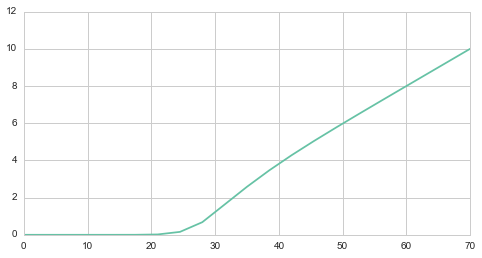

In [240]:
ax = df.iloc[:, -1].plot()

In [243]:
l_x = [-0.5, -0.5]
f_S0 = 31.68
res = minimize(best_price, l_x, tol=10e-6,
               args=(1., f_S0, na_V0, d, -1),
               bounds=((-1., -0.3),(-1., -0.3)),
               constraints=cons)
print res

  status: 0
 success: True
    njev: 2
    nfev: 8
     fun: -4.5554663347840902
       x: array([-0.3, -1. ])
 message: 'Optimization terminated successfully.'
     jac: array([-3.12358153,  3.26066738,  0.        ])
     nit: 2


In [244]:
f_S0 = 31.68
na_V0 = np.array([0.91, 4.63])
f1 = best_price([0., 0.], 1., f_S0, na_V0, d)
f2, df = best_price(res.x, 1., f_S0, na_V0, d, b_rtn_price=True)
print "I would buy at {:0.2f} without hedging".format(f1)
print "I would buy at {:0.2f} using hedging".format(f2)

I would buy at 1.63 without hedging
I would buy at 4.56 using hedging


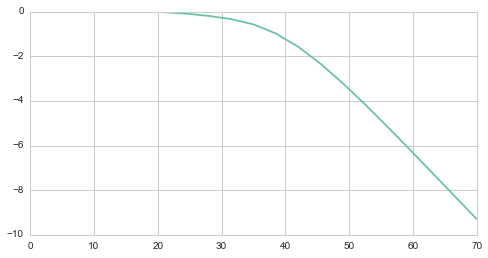

In [245]:
ax = df.iloc[:, -1].plot()

In [260]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 31.68,  # preco do ativo
           "f_sigma": (0.25 + 0.4)/2., # desvio padra do ativo objeto
           "f_time": 10e-6,  # tempo para vencimento em anos
           "f_r": 0.00,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "l_K": [29., 32., 35.],  # strike da opcao
           "l_Qty": [res.x[0], 1., res.x[1]]  # qtde por leg
          }

%time my_option = FlyEuropianCall(**d_param)

CPU times: user 133 ms, sys: 30.5 ms, total: 163 ms
Wall time: 143 ms


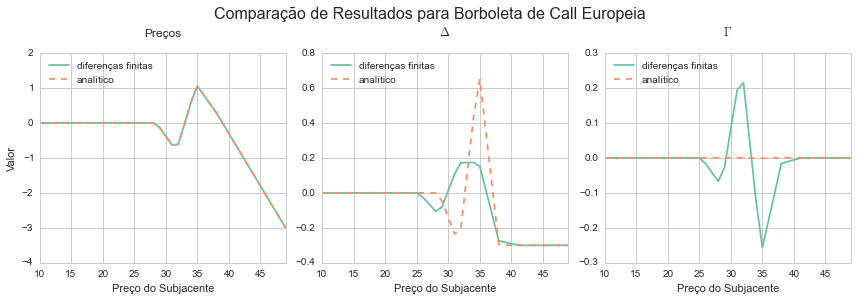

In [261]:
l_prices = np.arange(10., 50., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

CPU times: user 1.46 ms, sys: 341 µs, total: 1.8 ms
Wall time: 1.58 ms


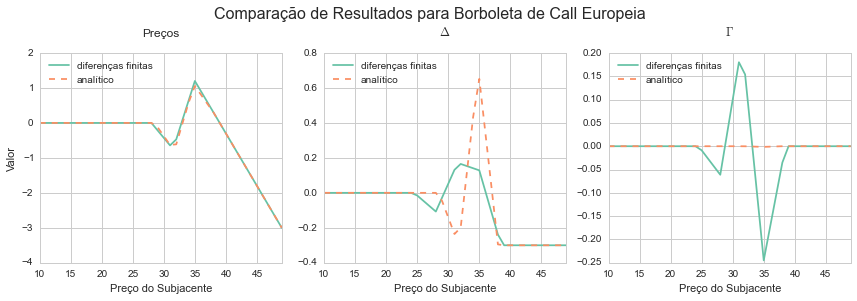

In [262]:
d = {'f_volm': 0.25,
     'f_volM': 0.40,
     'f_intrate': 0.00,
     's_ptype': 'C',
     'l_strike': [29., 32., 35.],
     'l_qty': [res.x[0], 1., res.x[1]],
     'f_expiration':10e-6,
     'f_NAS': 20.,
     'b_worstcase': True}
%time df_price, df_delta, df_gamma = opt_value_uvm_fly(**d)
my_option.df_delta = df_delta
my_option.df_opt_prices = df_price
my_option.df_gamma = df_gamma
l_prices = np.arange(10., 50., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

In [228]:
res.x

array([-0.3       , -0.97370293])

In [ ]:
d = {'f_volm': 0.25,
     'f_volM': 0.40,
     'f_intrate': 0.00,
     's_ptype': 'P',
     'l_strike': [29., 32., 35.],
     'l_qty': [0., 1., 0.],
     'f_expiration':1./3.,
     'f_NAS': 20.,
     'b_worstcase': True}

In [2]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [50]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))